In [1]:
import numpy as np

In [2]:
class AffineTransformationLayer:
    def __init__(self, input_size, output_size, weight_initializer, random_init_scaler=True):
        self.input_size = input_size
        self.output_size = output_size
        if weight_initializer == 'zeros':
            self.weights = np.zeros((input_size, output_size))
            self.bias = np.zeros((1, output_size))
        elif weight_initializer == 'normal_init':
            self.weights = np.random.normal(0, 0.1, (input_size, output_size))
            self.bias = np.random.normal(0, 0.1, (1, output_size))

    def forward(self, input):
        self.input = input
        return np.dot(input, self.weights) + self.bias

    def backward(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error

In [3]:
class ActivationLayer:
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime
    
    def forward(self, input):
        self.input = input
        return self.activation(input)
    
    def backward(self, output_error, learning_rate):
        return output_error * self.activation_prime(self.input)

In [4]:
class Reshaping_Layer:
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def forward(self, input):
        return np.reshape(input, (1, -1))
    
    def backward(self, output_error, learning_rate):
        return np.reshape(output_error, self.input_shape)

In [5]:
class SoftmaxLayer:
    def __init__(self, input_size):
        self.input_size = input_size
    
    def forward(self, input):
        self.input = input
        tmp = np.exp(input)
        self.output = tmp / np.sum(tmp)
        return self.output
    
    def backward(self, output_error, learning_rate):
        input_error = np.zeros(output_error.shape)
        out = np.tile(self.output.T, self.input_size)
        return self.output * np.dot(output_error, np.identity(self.input_size) - out)

In [6]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    return np.exp(-x) / (1 + np.exp(-x))**2

def relu(x):
    return np.maximum(x, 0)

def relu_prime(x):
    return np.array(x >= 0).astype('int')

In [7]:
def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / y_pred.size

In [8]:
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from fashion_mnist import *
x_train, y_train, x_val, y_val, x_test, y_test = load_data()

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (5.0.0)/charset_normalizer (2.0.10) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [9]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((48000, 784),
 (48000, 10),
 (12000, 784),
 (12000, 10),
 (10000, 784),
 (10000, 10))

In [10]:
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

In [11]:
class NeuralNetwork:
    def __init__(self, n_inputs,  input_shape, hidden_layer_sizes, n_outs, activation_fn, activation_fn_derivative, weight_initialization, loss, loss_prime):
        self.network = []
        self.network.append(Reshaping_Layer(input_shape))
        # Input To Hidden
        self.network.append(AffineTransformationLayer(n_inputs, hidden_layer_sizes[0], weight_initialization))
        self.network.append(ActivationLayer(activation_fn, activation_fn_derivative))
        # Hidden To Hidden
        for i in range(len(hidden_layer_sizes) - 1):
            self.network.append(AffineTransformationLayer(hidden_layer_sizes[i], hidden_layer_sizes[i+1], weight_initialization))
            self.network.append(ActivationLayer(activation_fn, activation_fn_derivative))
        # Hidden To Output
        self.network.append(AffineTransformationLayer(hidden_layer_sizes[-1], n_outs, weight_initialization))
        self.network.append(SoftmaxLayer(n_outs))
        self.loss = loss
        self.loss_prime = loss_prime
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []
    
    def predict(self, x):
        for layer in self.network:
            x = layer.forward(x)
        return x
    
    def fit(self, x_train, y_train, x_valid, y_valid, epochs=1000, learning_rate=0.1, batch_size=32, early_stopping=True, patience=10, verbose=True):
        x_batches_train = np.array_split(x_train, len(x_train)/ batch_size)
        y_batches_train = np.array_split(y_train, len(y_train)/ batch_size)
        for epoch in range(epochs):
            error = 0
            error_val = 0
            for x_train, y_train in zip(x_batches_train,y_batches_train):
                for x, y_true in zip(x_train, y_train):

                    output = x
                    
                    output = self.forward(output)

                    error += self.loss(y_true, output)

                    output_error = self.loss_prime(y_true, output)

                    self.backward(output_error, learning_rate)

                    error /= len(x_train)

            error_val = sum([self.loss(y, self.predict(x)) for x, y in zip(x_valid, y_valid)]) / len(x_valid) 

            self.train_loss.append(error)
            self.val_loss.append(error_val)
            train_acc = 0
            for x, y in zip(x_train, y_train):
                train_acc += accuracy(np.argmax(y), np.argmax(self.predict(x)))
            self.train_acc.append(train_acc / len(x_train))
            val_acc = 0
            for x, y in zip(x_valid, y_valid):
                val_acc += accuracy(np.argmax(y), np.argmax(self.predict(x)))
            self.val_acc.append(val_acc / len(x_valid))

            if early_stopping:
                if epoch > patience:
                    if self.train_loss[-1] > np.mean(self.val_loss[-(patience+1):-1]):
                        print('Early Stopping')
                        break
            if verbose:
                if epoch % 1 == 0:
                    print(f"Epoch: {epoch}, Training Loss: {error}, Validation Loss: {error_val}, Training Accuracy: {self.train_acc[-1]}, Validation Accuracy: {self.val_acc[-1]}")

    def forward(self, x):
        for layer in self.network:
            x = layer.forward(x)
        return x

    def backward(self, output_error, learning_rate):
        for layer in reversed(self.network):
            output_error = layer.backward(output_error, learning_rate)

    def predict_proba(self, x):
        return self.predict(x)

    def score(self, x, y):
        cnt = 0
        for x_v, y_v in zip(x,y):
            op = self.predict(x_v)
            if (np.argmax(op) == np.argmax(y_v)):
                cnt+=1
        return cnt/y.shape[0]

In [12]:
def save_model(model, filename):
    import pickle
    with open(f"Model_Saves/{filename}", 'wb') as f:
        pickle.dump(model, f)

def load_model(filename):
    import pickle
    with open(f"Model_Saves/{filename}", 'rb') as f:
        return pickle.load(f)

In [13]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((48000, 784), (48000, 10), (12000, 784), (12000, 10))

In [15]:
activation_fns = [relu, sigmoid]
activation_fns_prime = [relu_prime, sigmoid_prime]

In [16]:
for activation_fn, activation_fn_prime in zip(activation_fns, activation_fns_prime):
    for initialization in ['normal_init', 'zeros']:
        print(f"Activation Function: {activation_fn.__name__}, Initialization: {initialization}")
        model = NeuralNetwork(784, (28,28), [128], 10, activation_fn, activation_fn_prime, initialization, mse, mse_prime)
        model.fit(x_train, y_train, x_val, y_val, epochs=10, learning_rate=0.01, batch_size=128, early_stopping=True, patience=5, verbose=True)
        print(f"Accuracy: {model.score(x_test, y_test)}")
        save_model(model, f"model_{activation_fn.__name__}_{initialization}.pkl")

Activation Function: relu, Initialization: normal_init
Epoch: 0, Training Loss: 6.62511266004629e-05, Validation Loss: 0.027885831239256764, Training Accuracy: 0.7578125, Validation Accuracy: 0.8105833333333333
Epoch: 1, Training Loss: 0.00010168460715293936, Validation Loss: 0.024471652896687287, Training Accuracy: 0.8046875, Validation Accuracy: 0.8339166666666666
Epoch: 2, Training Loss: 0.00010611976723382688, Validation Loss: 0.02295407028297784, Training Accuracy: 0.828125, Validation Accuracy: 0.8439166666666666
Epoch: 3, Training Loss: 0.00011038349240663216, Validation Loss: 0.022086272331384157, Training Accuracy: 0.8515625, Validation Accuracy: 0.8500833333333333
Epoch: 4, Training Loss: 0.00011784509835937298, Validation Loss: 0.021503652618562845, Training Accuracy: 0.859375, Validation Accuracy: 0.8548333333333333
Epoch: 5, Training Loss: 0.00012660433968817765, Validation Loss: 0.02107892605216251, Training Accuracy: 0.8671875, Validation Accuracy: 0.8583333333333333
Epo

In [17]:
# Load Relu Model
relu_zero_model = load_model("model_relu_zeros.pkl")
relu_normal_model = load_model("model_relu_normal_init.pkl")

# Load Sigmoid Model
sigmoid_zero_model = load_model("model_sigmoid_zeros.pkl")
sigmoid_normal_model = load_model("model_sigmoid_normal_init.pkl")

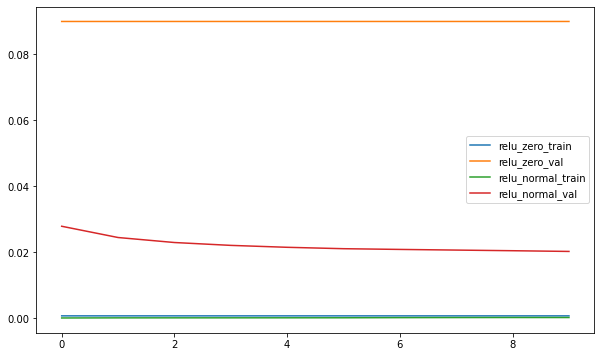

In [23]:
# Plot the training loss and validation loss for RELU
# fig size
plt.figure(figsize=(10, 6))
plt.plot(relu_zero_model.train_loss, label='relu_zero_train')
plt.plot(relu_zero_model.val_loss, label='relu_zero_val')
plt.plot(relu_normal_model.train_loss, label='relu_normal_train')
plt.plot(relu_normal_model.val_loss, label='relu_normal_val')
plt.legend()
plt.show()

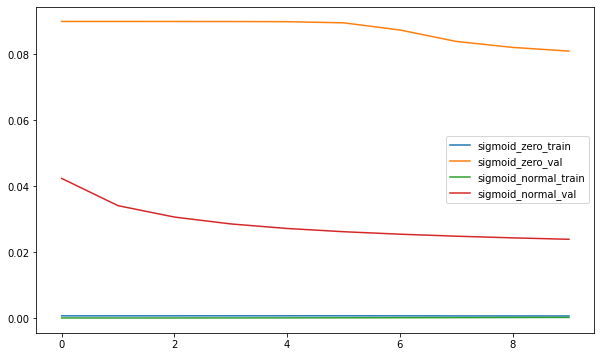

In [24]:
# Plot the training loss and validation loss for Sigmoid
# fig size
plt.figure(figsize=(10, 6))
plt.plot(sigmoid_zero_model.train_loss, label='sigmoid_zero_train')
plt.plot(sigmoid_zero_model.val_loss, label='sigmoid_zero_val')
plt.plot(sigmoid_normal_model.train_loss, label='sigmoid_normal_train')
plt.plot(sigmoid_normal_model.val_loss, label='sigmoid_normal_val')
plt.legend()
plt.show()

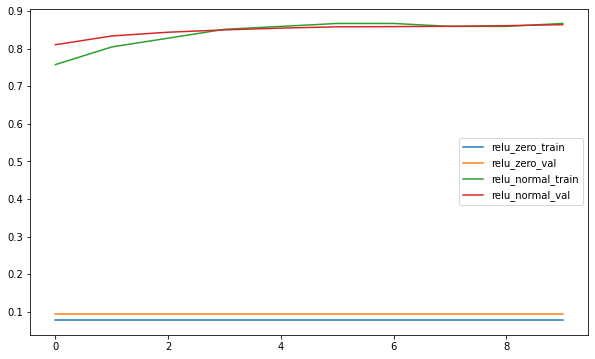

In [25]:
# Plot the training accuracy and validation accuracy for RELU
# fig size
plt.figure(figsize=(10, 6))
plt.plot(relu_zero_model.train_acc, label='relu_zero_train')
plt.plot(relu_zero_model.val_acc, label='relu_zero_val')
plt.plot(relu_normal_model.train_acc, label='relu_normal_train')
plt.plot(relu_normal_model.val_acc, label='relu_normal_val')
plt.legend()
plt.show()

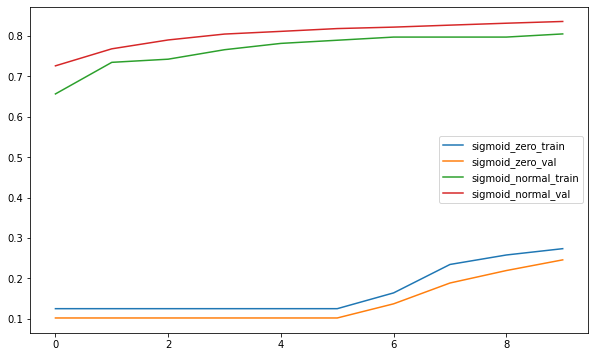

In [26]:
# Plot the training accuracy and validation accuracy for Sigmoid
# fig size
plt.figure(figsize=(10, 6))
plt.plot(sigmoid_zero_model.train_acc, label='sigmoid_zero_train')
plt.plot(sigmoid_zero_model.val_acc, label='sigmoid_zero_val')
plt.plot(sigmoid_normal_model.train_acc, label='sigmoid_normal_train')
plt.plot(sigmoid_normal_model.val_acc, label='sigmoid_normal_val')
plt.legend()
plt.show()